<a href="https://colab.research.google.com/github/Wh1t3-H4wk/UtalcaMLCourse/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
import pandas as pd
import numpy as np
import requests
import csv

In [2]:
data_url = "https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
data = requests.get(data_url)
lines = data.text.splitlines()
reader = csv.reader(lines, delimiter=';')
df = pd.DataFrame(reader, index=None)

In [3]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       82416 non-null  object 
 1   1       82416 non-null  object 
 2   2       57744 non-null  object 
 3   3       16485 non-null  object 
 4   4       2744 non-null   object 
 5   5       0 non-null      float64
dtypes: float64(1), object(5)
memory usage: 3.8+ MB


In [5]:
#Se elimina la quinta columna dado que no tiene datos
df = df[[0,1,2,3,4]].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       82416 non-null  object
 1   1       82416 non-null  object
 2   2       57744 non-null  object
 3   3       16485 non-null  object
 4   4       2744 non-null   object
dtypes: object(5)
memory usage: 3.1+ MB


In [6]:
df = df.iloc[1: , :]
df

,0,1,2,3,4
1,120707,0100,NaN,NaN,NaN
2,120707,0200,NaN,NaN,NaN
3,120707,0300,NaN,NaN,NaN
4,120707,0400,NaN,NaN,NaN
5,120707,0500,NaN,NaN,NaN
...,...,...,...,...,...
82411,211130,1900,NaN,3,NaN
82412,211130,2000,NaN,7,NaN
82413,211130,2100,NaN,7,NaN
82414,211130,2200,NaN,11,NaN


In [7]:
df[2]=df[2].str.replace(',','.')
df[3]=df[3].str.replace(',','.')
df[4]=df[4].str.replace(',','.')

df[2] = pd.to_numeric(df[2])
df[3] = pd.to_numeric(df[3])
df[4] = pd.to_numeric(df[4])

df.replace(np.nan, 0, regex=True, inplace=True)

In [8]:
trimmed_df = pd.DataFrame()
trimmed_df[0] = df[0] + df[1]
trimmed_df[1] = df[2] + df[3] + df[4]
trimmed_df.columns = ['ds','y']

In [9]:
trimmed_df.replace(0, np.nan, regex=True, inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82415 entries, 1 to 82415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      82415 non-null  object 
 1   y       76965 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


In [10]:
trimmed_df.dropna(inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76965 entries, 16 to 82415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      76965 non-null  object 
 1   y       76965 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [11]:
trimmed_df["ds"] = pd.to_datetime(trimmed_df["ds"], format='%y%m%d%H%M', errors='ignore')
trimmed_df

,ds,y
16,2012-07-07 16:00:00,33.7100
17,2012-07-07 17:00:00,53.9500
18,2012-07-07 18:00:00,96.3999
19,2012-07-07 19:00:00,67.4298
20,2012-07-07 20:00:00,163.2000
...,...,...
82411,2021-11-30 19:00:00,3.0000
82412,2021-11-30 20:00:00,7.0000
82413,2021-11-30 21:00:00,7.0000
82414,2021-11-30 22:00:00,11.0000


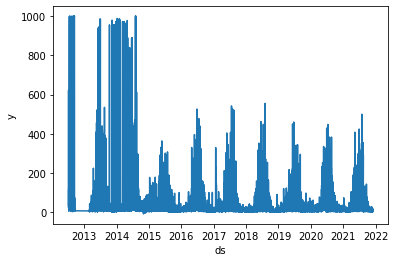

In [12]:
# plotting the line 2 points
plt.plot(trimmed_df["ds"], trimmed_df["y"])
 
# naming the x axis
plt.xlabel('ds')
# naming the y axis
plt.ylabel('y')

# function to show the plot
plt.show()

In [13]:
trimmed_df = trimmed_df.sort_values("ds")
train, test = train_test_split(trimmed_df, test_size=0.5, shuffle=False)

In [14]:
m = Prophet()
m.fit(train)

In [15]:
future = m.make_future_dataframe(periods=1095)
forecast = m.predict(future)

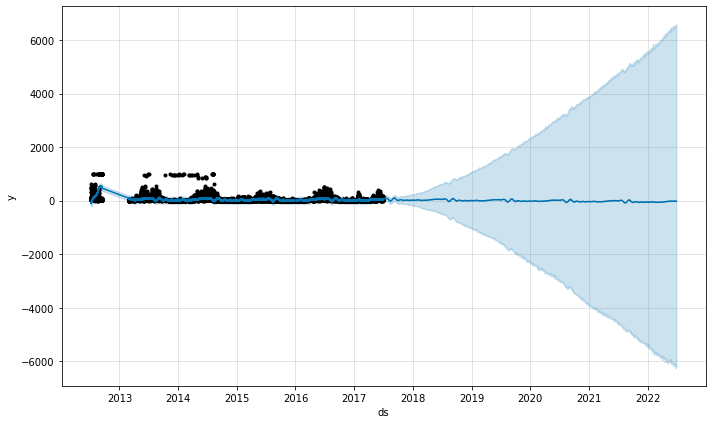

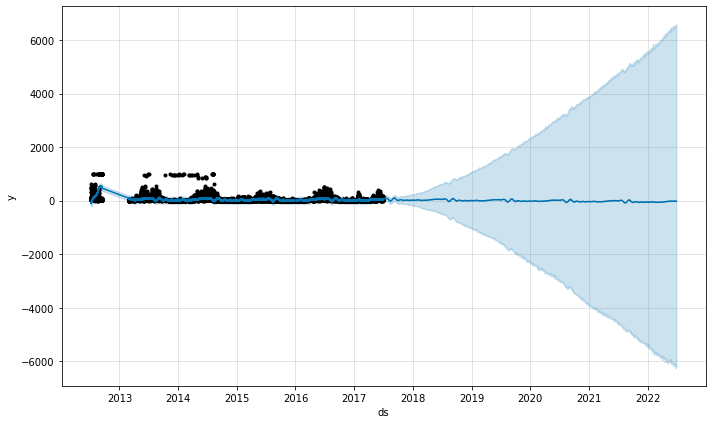

In [16]:
m.plot(forecast)

In [19]:
y_true = test['y'].values
y_pred = forecast['yhat'][-23090:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 31.742


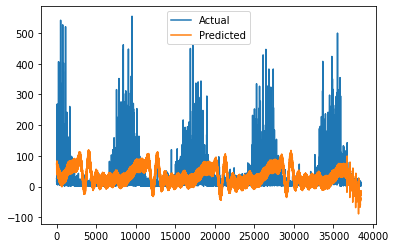

In [20]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()